# Notebook exercise - molecular descriptors

Molecular descriptors provide a way of encoding information about the structure or properties of a molecule in a primarily numerical form.

Roberto Todeschini and Viviana Consonni who literally wrote several books on molecular descriptors (including [this one](https://onlinelibrary.wiley.com/doi/book/10.1002/9783527628766) which you can access through UoL library) defined molecular descriptors as follows:

"*The molecular descriptor is the final result of a logic and mathematical procedure which transforms chemical information
encoded within a symbolic representation of a molecule into a useful number, or the result of some standardized experiment.*"[1]

:::{seealso}
[Some background on molecular descriptors, fingerprints and similarity](descriptors-similarity)
:::

### Aim of this notebook exercise

This notebook will look at an example of generating and visualising Morgan fingerprints - a type of circular topological fingerprint - for some relatively simple molecules using RDKit, and then assess their similarity using the Tanimoto-Jaccard coefficient. 

You saw how to calculate a Morgan fingerprint when you covered FAIR data in CHEM502, so some of this will be a recap and give you some practice wth RDKit.

In [2]:
# import statements - make sure to run this cell
import requests
import time

import numpy as np
import pandas as pd

from IPython.display import SVG

from rdkit import Chem
from rdkit.Chem import (
                        AllChem,
                        rdCoordGen,
                        Draw,
                        rdFingerprintGenerator,
                        PandasTools,
                        Descriptors
                        )
# from rdkit.Chem.Draw import rdMolDraw2D, 
# from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem.Draw import IPythonConsole
from rdkit import DataStructs

from IPython.display import SVG
from ipywidgets import interact,fixed,IntSlider


In [3]:
IPythonConsole.ipython_useSVG=True


### [RDKit](https://www.rdkit.org)

[RDKit docs](https://www.rdkit.org/docs/index.html)

RDKit [2] is an open-source cheminformatics toolkit used for handling chemical structures, molecular representations and computational chemistry tasks. It includes tools for descriptor calculation, generating molecular fingerprints, similarity searching, virtual screening and QSAR modelling.

One of RDKit’s key capabilities is computing a wide variety of molecular descriptors. You covered the basics of using RDKit in the FAIR data workshop in CHEM501. There are also some resources below that may be useful, particularly for calculating descriptors in RDKit.


[The RDKit Cookbook](https://www.rdkit.org/docs/Cookbook.html)

[List of available descriptors in the RDKit](https://www.rdkit.org/docs/GettingStartedInPython.html#list-of-available-descriptors)

[Calculating descriptors using RDKit](https://greglandrum.github.io/rdkit-blog/posts/2022-12-23-descriptor-tutorial.html)

[Fingerprints in the RDKit](https://www.rdkit.org/UGM/2012/Landrum_RDKit_UGM.Fingerprints.Final.pptx.pdf)


### Morgan (circular) fingerprints for some simple-ish example molecules

Molecular fingerprints are an abstract representation of features in a molecule, and can seem very abstract indeed. RDKit provides some methods to visualise how the bits in a fingerprint relate to fragments in the molecule, which can help to understand what the fingerprint actually represents.

There is a brief intro to Morgan fingerprints in RDKit in the [RDKit Getting Started](https://www.rdkit.org/docs/GettingStartedInPython.html#morgan-fingerprints-circular-fingerprints) guide.

In the cell below, there are some helper functions for generating and visualising the RDKit molecules and fingerprints.

In [4]:
# Helper functions for molecule and fingerprint generation and visualisation.
def get_2D_molecule(mol: Chem.Mol, addHs: bool=False) -> Chem.Mol:
    """Get rdkit.Mol with 2D coords"""

    if addHs:
        mol = Chem.AddHs(mol) if addHs else mol     
    rdCoordGen.AddCoords(mol)
    return mol

def get_3D_molecule(mol: Chem.Mol) -> Chem.Mol:
    """Get rdkit.Mol with 3D coords"""

    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    return mol

def get_molecule_from_smiles(smiles: str, addHs: bool=False, make3D: bool=False) -> Chem.Mol:
    """Get rdkit.Mol from SMILES"""
    
    mol =  Chem.MolFromSmiles(smiles)
    if make3D:
        mol = get_3D_molecule(mol)
    else:
        mol = get_2D_molecule(mol, addHs=addHs)
    return mol

def draw_2D_molecule(mol: Chem.Mol, addLabels: bool=False, forFP: bool=False) -> Draw.MolDraw2DSVG:
    """Draw 2D molecule"""
    
    d2d = Draw.MolToImage(mol)
    if addLabels:
        for atom in mol.GetAtoms():
            # For each atom, set the property "atomNote" to a index+1 of the atom
            if forFP:
                atom.SetProp("atomNote", str(atom.GetIdx()))
            else:
                atom.SetProp("atomNote", str(atom.GetIdx()+1))    
    return d2d


def get_Morgan_fingerprint_with_bits(mol: Chem.Mol, radius: int=2, fpSize: int=2048) -> tuple:
    """Get Morgan fingerprint and its bit information map"""

    mfp_gen = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=fpSize)
    ao = rdFingerprintGenerator.AdditionalOutput()
    ao.CollectBitInfoMap()
    mfp = mfp_gen.GetFingerprint(mol, additionalOutput=ao)
    bit_info = ao.GetBitInfoMap()
    return mfp, bit_info 

def get_Morgan_fingerprint_with_ao(mol, radius=2, fpSize=2048):
    """Get Morgan fingerprint and its additional output"""
    mfp_gen = rdFingerprintGenerator.GetMorganGenerator(radius=radius,fpSize=fpSize)
    
    ao = rdFingerprintGenerator.AdditionalOutput()
    ao.AllocateAtomCounts()
    ao.AllocateAtomToBits()
    ao.AllocateBitInfoMap()
    
    mfp = mfp_gen.GetFingerprint(mol, additionalOutput=ao)
    return mfp, ao

def draw_Morgan_fps_with_bits(mol: Chem.Mol, mfp, bit_info: dict) -> Draw.MolDraw2DSVG:
    """Get SVG drawer for grid of Morgan fingerprints with bits highlighted"""

    on_bits_list = [(mol, bit_idx, bit_info, atom_info) for bit_idx in mfp.GetOnBits() for atom_info in range(len(bit_info[bit_idx]))]
    labels = [f"Bit {str(i[1])}" for i in on_bits_list]
    d = Draw.DrawMorganBits(on_bits_list, molsPerRow=5, legends=labels)  # Draw the on bits
    return d

def save_Morgan_fps_with_bits(mol, mfp, bit_info) -> Draw.MolDraw2DSVG:
    """Get drawer of grid of Morgan fingerprints with bits highlighted to save as png"""

    on_bits_list = [(mol, bit_idx, bit_info, atom_info) for bit_idx in mfp.GetOnBits() for atom_info in range(len(bit_info[bit_idx]))]
    labels = [f"Bit {str(i[1])}" for i in on_bits_list]
    drawOptions = Draw.rdMolDraw2D.MolDrawOptions()
    drawOptions.prepareMolsBeforeDrawing = False
    drawOptions.legendFontSize = 60
    d = Draw.DrawMorganBits(on_bits_list, molsPerRow=5, legends=labels, subImgSize=(300, 300), useSVG=False, drawOptions=drawOptions)  # Draw the on bits
    return d


def renderFpBit(mol, bit_idx, bit_info,fn):
    return (display(fn(mol, bit_idx, bit_info)))

def draw_interactive_Morgan_fps_with_bits(mol, bit_info):
    """Draw Morgan fingerprints with bits highlighted with interactive bit selection"""

    interact(renderFpBit, bit_idx=list(bit_info.keys()),mol=fixed(mol),
            bit_info=fixed(bit_info),fn=fixed(Draw.DrawMorganBit));

#### Find SMILES for some common compounds

To start with, we will acquire the SMILES strings of some well known compounds. In case you need a SMILES recap: [Daylight theory](https://www.daylight.com/dayhtml/doc/theory/theory.smiles.html), [quick tutorial](https://chemicbook.com/2021/02/13/smiles-strings-explained-for-beginners-part-1.html).

The [Chemical Identifier Resolver](https://cactus.nci.nih.gov/chemical/structure) (CIR) service is run by the CADD Group at the NCI/NIH as part of their [Cactus server](https://cactus.nci.nih.gov).

In addition to its [web interface](https://cactus.nci.nih.gov/chemical/structure), it has an easy-to-use URL API: You can supply a chemical identifier and requests that it returns a representation of a specified type as a string. As well as allowing searches by various molecular representations, you can also search by and for IUPAC Names and even non-standard names. WYou can see the in/output formats it can handle on the web interface.

Cactus API urls have the form: `https://cactus.nci.nih.gov/chemical/structure/<structure identifier>/<representation>` so we can use the `requests` library to programmatically access representations for compounds. 

You used `requests` for API access in CHEM502. Check the [quickstart guide](https://requests.readthedocs.io/en/latest/user/quickstart/) for a reminder.


In [5]:
ROOT_URL = "https://cactus.nci.nih.gov/chemical/structure/"

# For example, to retrieve the InChIKey for the structure with the SMILES "c1ccccc1", we would use the following URL:
identifier = "c1ccccc1"
representation = "stdinchikey"

query_url = f"{ROOT_URL}{identifier}/{representation}"

response = requests.get(query_url)

if response:
    print(response.text)
else:
    raise Exception(f"Cactus request failed: {response.status_code}")



InChIKey=UHOVQNZJYSORNB-UHFFFAOYSA-N


In [6]:
# Let's try getting a SMILES representation based on a common, non-systematic name for a compound.

identifier = "aspirin"
representation = "smiles"

query_url = f"{ROOT_URL}{identifier}/{representation}"

response = requests.get(query_url)
if response:
    print(response.text)
else:
    raise Exception(f"Cactus request failed: {response.status_code}")



CC(=O)Oc1ccccc1C(O)=O


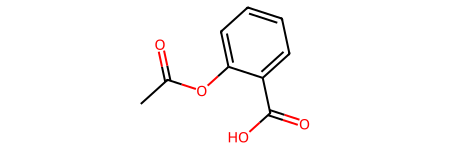

In [8]:
# We can create an RDKit molecule from the SMILES string and visualise to check it is actually aspirin.
# In 2D, ChemDraw graph style:

aspirin = Chem.MolFromSmiles(response.text)
aspirin

In [9]:
# And a 3D view:
IPythonConsole.drawMol3D(aspirin)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Does it agree with what Wikipedia thinks aspirin looks like? 

[Aspirin on wiki](https://en.wikipedia.org/wiki/Aspirin)

It looks like that is the correct SMILES for aspirin.


In [ ]:
# Here is a function so the process of getting the SMILES can be repeated for multiple compounds.
# It includes a sleep time (`time.sleep`) to avoid overloading the server.

def get_smiles_from_name(name):
    """Get SMILES string from name using Cactus web service"""
    ROOT_URL = "https://cactus.nci.nih.gov/chemical/structure/"
    identifier = name
    representation = "smiles"

    query_url = f"{ROOT_URL}{identifier}/{representation}"

    response = requests.get(query_url)
    time.sleep(0.05)
    if response:
        return response.text
    else:
        raise Exception(f"Cactus request failed: {response.status_code}")


In [10]:

compounds = ["epinephrine", "ibuprofen", "dopamine", "caffeine", "naproxen", "paracetamol", "paraxanthine", "vanillin",
             "adenosine", "aspirin", "niacinamide", "theobromine", "diclofenac", "theophylline", "amphetamine"]

compounds_smiles = {compound: get_smiles_from_name(compound) for compound in compounds}
compounds_smiles

{'epinephrine': 'CNC[C@H](O)c1ccc(O)c(O)c1',
 'ibuprofen': 'CC(C)Cc1ccc(cc1)C(C)C(O)=O',
 'dopamine': 'NCCc1ccc(O)c(O)c1',
 'caffeine': 'Cn1cnc2N(C)C(=O)N(C)C(=O)c12',
 'naproxen': 'COc1ccc2cc(ccc2c1)C(C)C(O)=O',
 'paracetamol': 'CC(=O)Nc1ccc(O)cc1',
 'paraxanthine': 'Cn1cnc2NC(=O)N(C)C(=O)c12',
 'vanillin': 'COc1cc(C=O)ccc1O',
 'adenosine': 'Nc1ncnc2n(cnc12)[C@@H]3O[C@H](CO)[C@@H](O)[C@H]3O',
 'aspirin': 'CC(=O)Oc1ccccc1C(O)=O',
 'niacinamide': 'NC(=O)c1cccnc1',
 'theobromine': 'Cn1cnc2N(C)C(=O)NC(=O)c12',
 'diclofenac': 'OC(=O)Cc1ccccc1Nc2c(Cl)cccc2Cl',
 'theophylline': 'CN1C(=O)N(C)c2nc[nH]c2C1=O',
 'amphetamine': 'CC(N)Cc1ccccc1'}

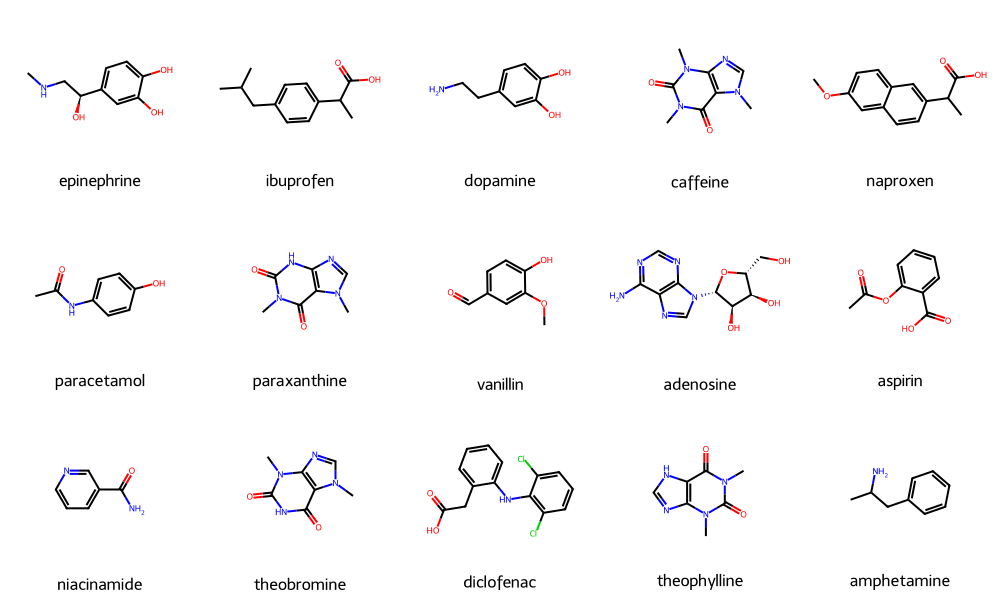

In [11]:
# Visualise the molecules

mols = [Chem.MolFromSmiles(smiles) for smiles in compounds_smiles.values()]
Draw.MolsToGridImage(mols, molsPerRow=5, legends=compounds_smiles.keys())

### Generating a Morgan fingerprint

We will use niacinamide to see an example of generating its Morgan fingerprint and looking at the information encoding in its bit vector.


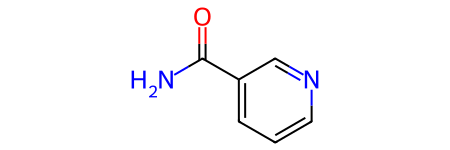

In [12]:
niacinamide = get_molecule_from_smiles(compounds_smiles["niacinamide"])
niacinamide

The Morgan fingerprint (MFP) is a type of circular fingerprint that encodes the presence of substructures in the molecule.

The fingerprint can be obtained as a bit vector (a binary array of 0s and 1s) or as a set of counts.

- In the bit vector, an 'on' bit, i.e. a "1", indicates the presence of a particular substructure in the molecule.

- The count-based fingerprint also stores the frequency that the substructure occurs.


Here we will see the fingerprint as a bit vector. You can see the function used to generate the MFP further up in the notebook. It uses an RDKit [Morgan fingerprint generator](https://www.rdkit.org/docs/source/rdkit.Chem.rdFingerprintGenerator.html#rdkit.Chem.rdFingerprintGenerator.GetMorganGenerator) to create a fingerprint of a molecule.

The function then returns the fingerprint and a bit information map that can be used to highlight the substructures in the molecule that correspond to the bits in the fingerprint.


In [13]:
niacinamide_mfp, niacinamide_bi = get_Morgan_fingerprint_with_bits(niacinamide)
display(type(niacinamide_mfp), type(niacinamide_bi))

rdkit.DataStructs.cDataStructs.ExplicitBitVect

dict

In [14]:
# Display the fingerprint in the form of a bit matrix (the array of 2048 bits is split into 16 rows of 128 bits just to dispaly more easily)

bits = np.array(niacinamide_mfp).reshape(16,128)
for row in bits:
    print(*row)

# show the number of bits that are on
print(f"Number of on bits (value is 1): {niacinamide_mfp.GetNumOnBits()}")

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

### Interpreting bit information

The bit information map is a dictionary where the keys are the bit indices and the values are sets of pair tuples describing the fragment that contribute to that bit. 

The pair tuples are of the form `(atomId, radius)` where `atomId` is the index of central atom and the `radius` is the extent of the circle (number of bonds from the central atom) covering the fragment.



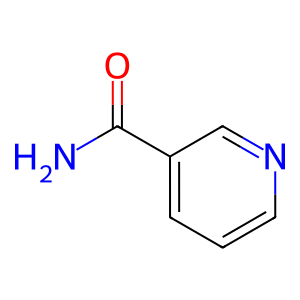

{140: ((0, 1),),
 309: ((1, 1),),
 378: ((7, 0),),
 437: ((6, 2),),
 650: ((2, 0),),
 807: ((1, 0),),
 1043: ((5, 2),),
 1088: ((5, 1),),
 1171: ((0, 0),),
 1177: ((3, 2),),
 1380: ((3, 0),),
 1385: ((3, 1),),
 1535: ((8, 1),),
 1586: ((7, 2),),
 1603: ((7, 1),),
 1727: ((1, 2),),
 1750: ((4, 1),),
 1866: ((6, 1),),
 1873: ((4, 0), (5, 0), (6, 0), (8, 0)),
 1917: ((2, 1),),
 1962: ((8, 2),),
 1985: ((4, 2),)}

In [15]:
display(draw_2D_molecule(niacinamide, forFP=True, addLabels=True))

niacinamide_bi

From the niacinamide MFP, the first entry in bit info dictionary is for bit 140:

    140: ((0, 1),)

Starting at the atom at index 0 - the diagram shows this is the primary amine nitrogen - and drawing a circle that encloses atoms one bond away locates a pattern in the molecule that matches whatever substructure is represented by bit 140. 

You can see there can be some bits where more than atom's environment also contributes to the same bit (bit 1873 for niacinamide). This is a [*bit collision*](https://chemicbook.com/2021/03/25/a-beginners-guide-for-understanding-extended-connectivity-fingerprints.html#:~:text=bit%20collision) and can cause some information loss which could affect further computations based on the fingerprint - particularly relevant for machine learning performance - if the collisions are extensive. 

Making the fingerprint larger can help to reduce bit collisions, but comes with computational expense. Using a count-based MFP rather than the bit vector means that information about the number of number of atom environments for a bit are retained, so count-based MFPs may be preferred if the fingerprint will be used in ML.


#### Visualising bits in the Morgan fingerprint

The parts of the molecule contributing to the 'on' bits (bits with a value of 1) can also be visualised.

The colors of the Morgan bits' highlights indicate the nature of the atoms in the neighbouring environment of the central atom. The radius for this fingerprint was set to 2, so it considers the local environment of the central atom up to atoms two bonds away.

**Blue** - central atom in the environment

**Yellow** - aromatic atoms

**Grey** - aliphatic ring atoms

<strong>* + faint grey bonds</strong> - an atom not part of the bit, but shows the connectivity of atoms that are.

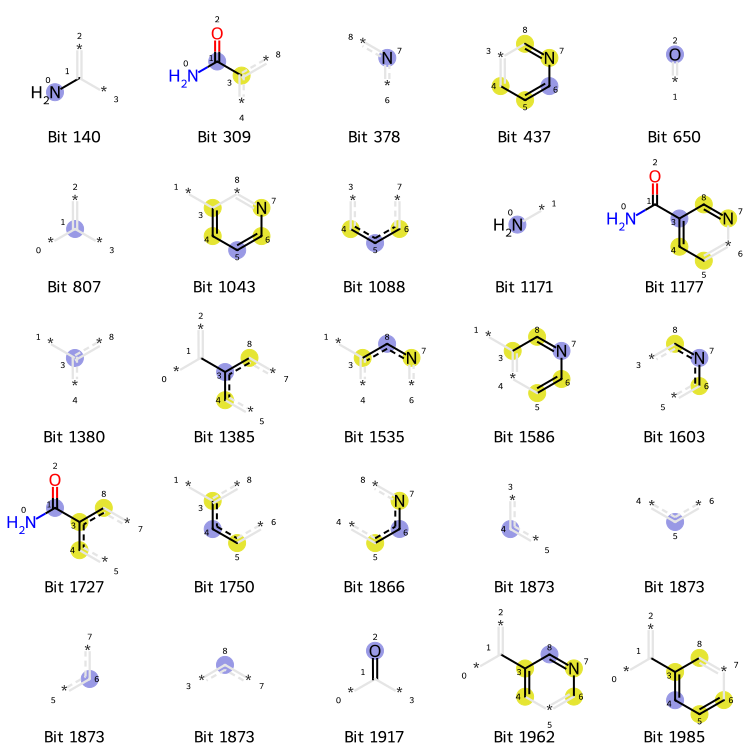

In [16]:
# Use rdkit to draw the fragments corresponding to the on bits in the bit information map
i = draw_Morgan_fps_with_bits(niacinamide, niacinamide_mfp, niacinamide_bi)
i

This makes it striaghtforward to infer that bit 1873 encodes the presence of unsubtituted aromatic carbon. There may be additional criteria, but carbons 4, 5, 6, 8 all match the substructure.

In [17]:
# img = save_Morgan_fps_with_bits(niacinamide, niacinamide_mfp, niacinamide_bi)
# img.save("niacinamide_mfp.png")

**Short notebook fanciness diversion**

You can use ipywidgets to create a visualisation of the bits in a notebook that lets you select which bit you want to view:


In [18]:
draw_interactive_Morgan_fps_with_bits(niacinamide, niacinamide_bi)

interactive(children=(Dropdown(description='bit_idx', options=(140, 309, 378, 437, 650, 807, 1043, 1088, 1171,…

## Molecular Similarity

One of the major uses of **molecular fingerprints** is to assess **molecular similarity** by comparing the bit vectors (or count vectors) of different molecules.

We can generate fingerprints for our small collection of molecules, then using one as a reference, calculate a measure of how similar the other molecules are to that molecule.

To start with, we will use caffeine as the reference and locate which of the other compounds are most similar.

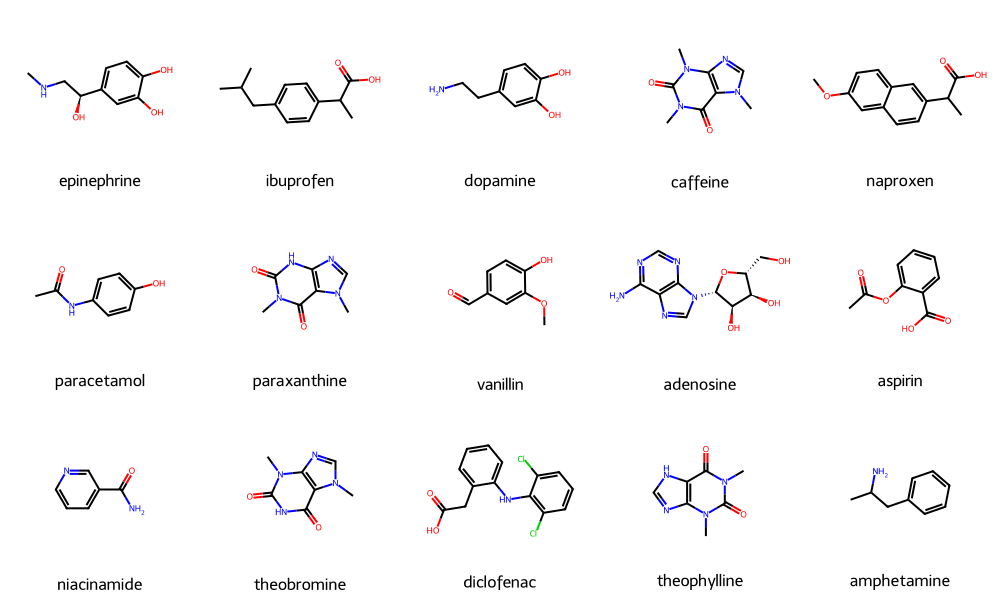

In [19]:
# A quick reminder of the compounds we are working with:

Draw.MolsToGridImage(mols, molsPerRow=5, legends=compounds_smiles.keys())


The RDKit has a module for working with molecules in Pandas, which can be particularly useful if you are dealing with a significant amount of molecules or data.

[PandasTools module](https://www.rdkit.org/docs/source/rdkit.Chem.PandasTools.html)

In [20]:
# create a pandas DataFrame with the name and SMILES for each compound

mols_df = pd.DataFrame.from_dict(compounds_smiles, orient="index", columns=["SMILES"]).reset_index().rename(columns={"index": "name"})
mols_df

,name,SMILES
0,epinephrine,CNC[C@H](O)c1ccc(O)c(O)c1
1,ibuprofen,CC(C)Cc1ccc(cc1)C(C)C(O)=O
2,dopamine,NCCc1ccc(O)c(O)c1
3,caffeine,Cn1cnc2N(C)C(=O)N(C)C(=O)c12
4,naproxen,COc1ccc2cc(ccc2c1)C(C)C(O)=O
5,paracetamol,CC(=O)Nc1ccc(O)cc1
6,paraxanthine,Cn1cnc2NC(=O)N(C)C(=O)c12
7,vanillin,COc1cc(C=O)ccc1O
8,adenosine,Nc1ncnc2n(cnc12)[C@@H]3O[C@H](CO)[C@@H](O)[C@H]3O
9,aspirin,CC(=O)Oc1ccccc1C(O)=O


,name,SMILES,ROMol
0,epinephrine,CNC[C@H](O)c1ccc(O)c(O)c1,
1,ibuprofen,CC(C)Cc1ccc(cc1)C(C)C(O)=O,
2,dopamine,NCCc1ccc(O)c(O)c1,
3,caffeine,Cn1cnc2N(C)C(=O)N(C)C(=O)c12,
4,naproxen,COc1ccc2cc(ccc2c1)C(C)C(O)=O,
5,paracetamol,CC(=O)Nc1ccc(O)cc1,
6,paraxanthine,Cn1cnc2NC(=O)N(C)C(=O)c12,
7,vanillin,COc1cc(C=O)ccc1O,
8,adenosine,Nc1ncnc2n(cnc12)[C@@H]3O[C@H](CO)[C@@H](O)[C@H]3O,
9,aspirin,CC(=O)Oc1ccccc1C(O)=O,

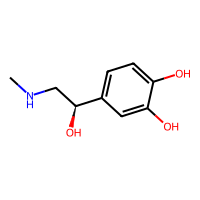
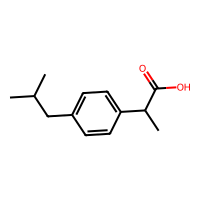
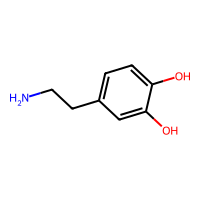
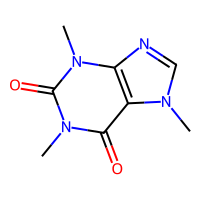
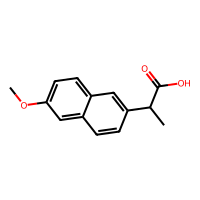
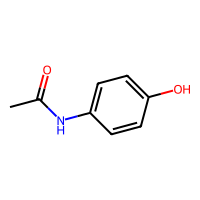
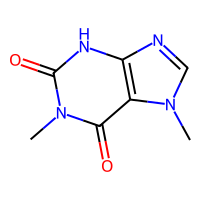
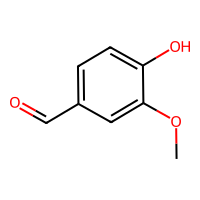
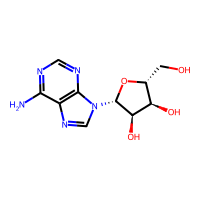
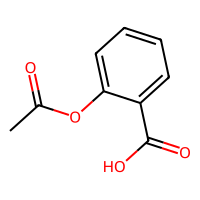
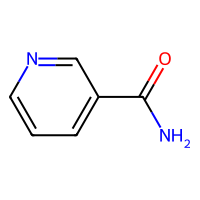
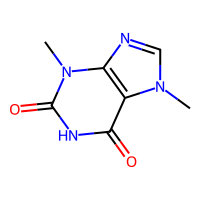
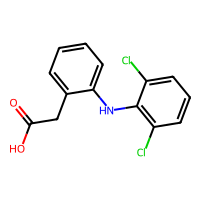
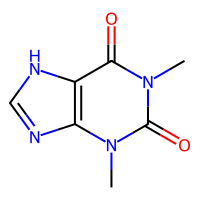
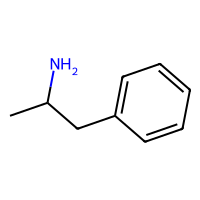

In [21]:
# We could use the existing list of RDKit molecules to add a column to the DataFrame, but we will use the SMILES strings 
# to generate the molecules again to show how to use the `PandasTools` module. The "ROMol" column will contain the RDKit molecules.

PandasTools.AddMoleculeColumnToFrame(mols_df, smilesCol="SMILES")
mols_df

,name,SMILES,ROMol,Morgan_fingerprint
0,epinephrine,CNC[C@H](O)c1ccc(O)c(O)c1,,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,ibuprofen,CC(C)Cc1ccc(cc1)C(C)C(O)=O,,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,dopamine,NCCc1ccc(O)c(O)c1,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,caffeine,Cn1cnc2N(C)C(=O)N(C)C(=O)c12,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,naproxen,COc1ccc2cc(ccc2c1)C(C)C(O)=O,,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,paracetamol,CC(=O)Nc1ccc(O)cc1,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,paraxanthine,Cn1cnc2NC(=O)N(C)C(=O)c12,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,vanillin,COc1cc(C=O)ccc1O,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,adenosine,Nc1ncnc2n(cnc12)[C@@H]3O[C@H](CO)[C@@H](O)[C@H]3O,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,aspirin,CC(=O)Oc1ccccc1C(O)=O,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."

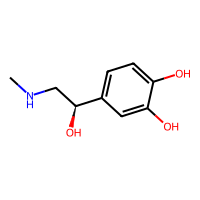
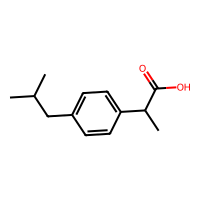
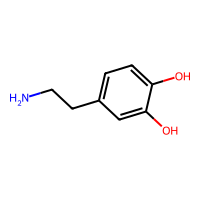
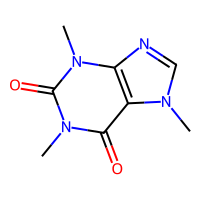
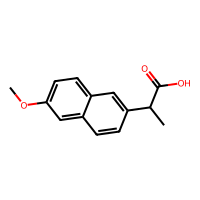
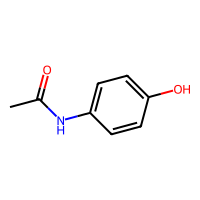
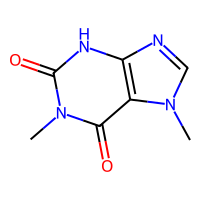
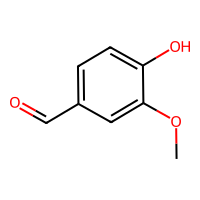
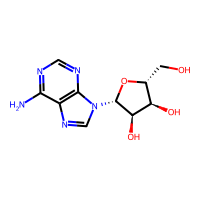
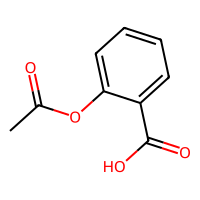
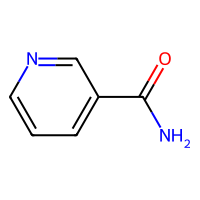
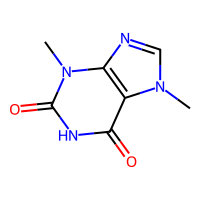
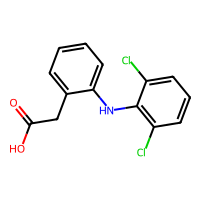
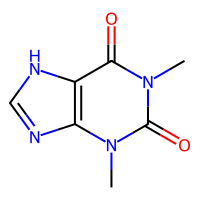
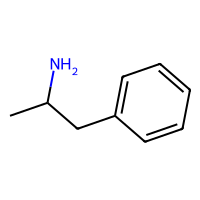

In [22]:
# We can then add the Morgan fingerprints to the DataFrame.

mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)

mols_df["Morgan_fingerprint"] = mols_df["ROMol"].map(lambda x: mfpgen.GetFingerprint(x))
mols_df

,name,SMILES,ROMol,Morgan_fingerprint,Tanimoto_similarity_caffeine
0,epinephrine,CNC[C@H](O)c1ccc(O)c(O)c1,,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.062500
1,ibuprofen,CC(C)Cc1ccc(cc1)C(C)C(O)=O,,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.086957
2,dopamine,NCCc1ccc(O)c(O)c1,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.045455
3,caffeine,Cn1cnc2N(C)C(=O)N(C)C(=O)c12,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000
4,naproxen,COc1ccc2cc(ccc2c1)C(C)C(O)=O,,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.080000
5,paracetamol,CC(=O)Nc1ccc(O)cc1,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.097561
6,paraxanthine,Cn1cnc2NC(=O)N(C)C(=O)c12,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.485714
7,vanillin,COc1cc(C=O)ccc1O,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.086957
8,adenosine,Nc1ncnc2n(cnc12)[C@@H]3O[C@H](CO)[C@@H](O)[C@H]3O,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.122807
9,aspirin,CC(=O)Oc1ccccc1C(O)=O,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.088889

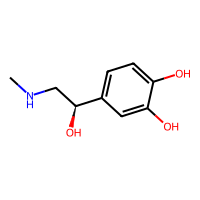
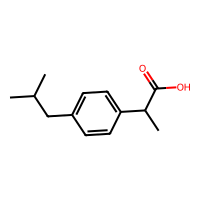
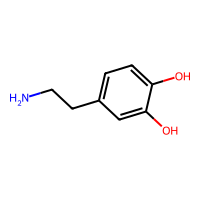
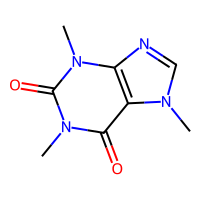
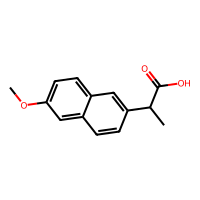
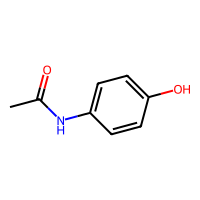
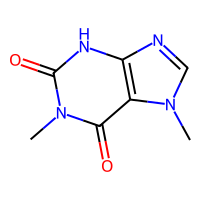
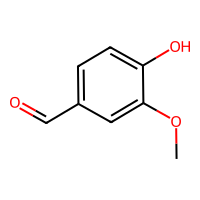
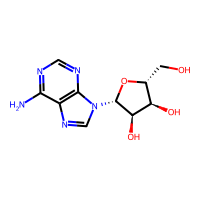
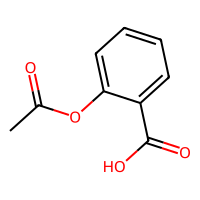
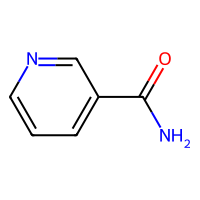
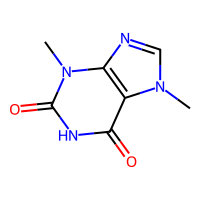
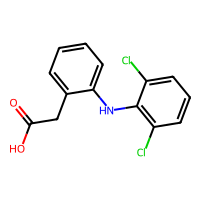
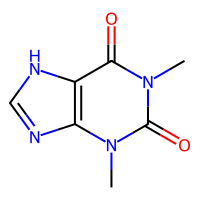
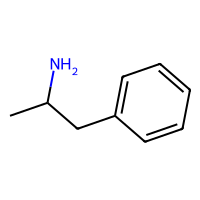

In [23]:
# Finally, we can calculate the Tanimoto similarity between the caffeine molecule and each of the other molecules in the DataFrame.

mols_df["Tanimoto_similarity_caffeine"] = mols_df["Morgan_fingerprint"].map(lambda x: DataStructs.TanimotoSimilarity(mols_df["Morgan_fingerprint"][3], x))

mols_df

In [24]:
# To see which molecule is most similar to caffeine, we can sort the DataFrame by the Tanimoto similarity.

mols_df.sort_values("Tanimoto_similarity_caffeine", ascending=False)

,name,SMILES,ROMol,Morgan_fingerprint,Tanimoto_similarity_caffeine
3,caffeine,Cn1cnc2N(C)C(=O)N(C)C(=O)c12,<rdkit.Chem.rdchem.Mol object at 0x146c98430>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000
11,theobromine,Cn1cnc2N(C)C(=O)NC(=O)c12,<rdkit.Chem.rdchem.Mol object at 0x146c98820>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.529412
6,paraxanthine,Cn1cnc2NC(=O)N(C)C(=O)c12,<rdkit.Chem.rdchem.Mol object at 0x146c98580>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.485714
13,theophylline,CN1C(=O)N(C)c2nc[nH]c2C1=O,<rdkit.Chem.rdchem.Mol object at 0x146c98a50>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.457143
8,adenosine,Nc1ncnc2n(cnc12)[C@@H]3O[C@H](CO)[C@@H](O)[C@H]3O,<rdkit.Chem.rdchem.Mol object at 0x146c986d0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.122807
5,paracetamol,CC(=O)Nc1ccc(O)cc1,<rdkit.Chem.rdchem.Mol object at 0x146c98660>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.097561
10,niacinamide,NC(=O)c1cccnc1,<rdkit.Chem.rdchem.Mol object at 0x146c98900>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.093023
9,aspirin,CC(=O)Oc1ccccc1C(O)=O,<rdkit.Chem.rdchem.Mol object at 0x146c98740>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.088889
1,ibuprofen,CC(C)Cc1ccc(cc1)C(C)C(O)=O,<rdkit.Chem.rdchem.Mol object at 0x146c983c0>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.086957
7,vanillin,COc1cc(C=O)ccc1O,<rdkit.Chem.rdchem.Mol object at 0x146c985f0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.086957


The Tanimoto similarity coefficient shows that theobromine, paraxanthine and theophylline are clearly much more similar to caffeine than the other compounds in the set.

- Is this what you expect just from considering the molecular structures?
- Do you know anything else about this set of molecules that explains why they are quite closely related?



#### For you to try:

- Try changing the radius over which the Morgan fingerprint is calculated (the value is passed when you create the fingerprint generator). What difference does this make to the Tanimoto score calculated for the new fingerprint? Can you explain why?
- Try generating a different type of fingerprint, e.g. an RDKit fingerprint, and see how different the Tanimoto coefficients for that type of fingerprint are.
- RDKit has drawing tools to draw [Similarity Maps](https://www.rdkit.org/docs/GettingStartedInPython.html#generating-similarity-maps-using-fingerprints). See if you can generate a map to compare caffeine with one of the related compounds.
- Choose a different compound as the reference and to identify any other groups of related molecules in the set.

#### References

1) R. Todeschini and V. Consonni, *Handbook of Molecular Descriptors*, Wiley-VCH, Weinheim, 2000. https://doi.org/10.1002/9783527613106
1) *RDKit: Open-source cheminformatics.* https://www.rdkit.org